## Analysis of 1st day in the RCF study
Checking amygdala activation in the CS+US condition of the task
- masking amygdala
- avergaing activation
- plot

In [1]:
# load libraries
import glob
import pandas as pd
import numpy as np
import nilearn
import nilearn.plotting
import nilearn.input_data
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import cmdstanpy
import arviz as az

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
## Screening subjects by SCR as Nachshon analyzed - 67% as US:
subject_list = ['029','040','1074','1205','1223','1237','1245','1247',
               '1280','1301','1337','1350','1359','1374','1392','020',
               '1072','1099','1206','1212','1216','1258','1266','1268',
               '1320','1340','1345','1346','1362','1379','1393','1457','1460',
               '1373','1272','1291','1309', '1210','1218','1221','1303','1312','1326','1338'] # '1269','1271','1319', '1220','1376',
len(subject_list)

44

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/nilearn/_utils/helpers.py:145: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  return func(*args, **kwargs)


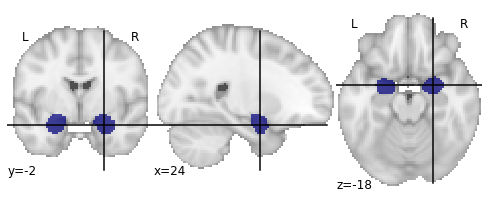

In [3]:
# load mask
mask_file = 'amygdala_association-test_z_FDR_0.01.nii.gz'
mask_file = nilearn.image.math_img("a>=20", a=mask_file)
%matplotlib inline
nilearn.plotting.plot_roi(mask_file)
plt.savefig('amygdalaMask.eps',format='eps')

# create a masker 
fwhm = 4
masker = nilearn.input_data.NiftiMasker(mask_img=mask_file, 
                               sessions=None, smoothing_fwhm=fwhm, standardize=False, 
                                        detrend=False, verbose=5)

In [4]:
#us_cond = '/media/Data/work/RCF_FSLNoScrub/Sink_respNOScrub/1stLevel/_subject_id_{sub}/_modelestimate0/results/cope{cope_num}.nii.gz'
us_cond = '/media/Data/work/RCF_FSLNoScrub/Sink_respNOScrub/1stLevel/_subject_id_{sub}/_modelestimate0/results/zstat{cope_num}.nii.gz'
cope_num =  4#taking shock vs. noshock


In [5]:
us = []
timeseriesAmg = []
counter = 1 # set counter to give percentage of progress
for sub in subject_list:
   # try:
    func = us_cond.format(sub=sub, cope_num= cope_num)
    print(func)
    sub = func.split('id_')[1].split('/')[0]
    print(sub)
    print(f'\nFinished {counter/len(subject_list)*100}% of subjects')
    counter = counter +1 
    # amygdala
    tArr = masker.fit_transform(func)
    meanT = np.mean(tArr,axis=1)
    sem = scipy.stats.sem(tArr, axis=1)
    std = np.std(tArr, axis=1)
    

    # create datafram for the timeseries
    dfTS = {'subject':sub, 'ts':tArr[0]}
    # create dataframe for the mean activation
    df = {'subject':sub, 'amygdala':meanT[0], 'amgsem':sem[0], 'amgstd':std[0]}
    #df['subject'] = sub
    us.append(df)
    timeseriesAmg.append(dfTS)
    #except:
     #   print(f'Subject {sub} has no data')
amg_ud = pd.DataFrame(us)
tsDf = pd.DataFrame(timeseriesAmg)

/media/Data/work/RCF_FSLNoScrub/Sink_respNOScrub/1stLevel/_subject_id_029/_modelestimate0/results/zstat4.nii.gz
029

Finished 2.272727272727273% of subjects
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,    1. ]])
)
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
/media/Data/work/RCF_FSLNoScrub/Sink_respNOScrub/1stLevel/_subject_id_040/_modelestimate0/results/zstat4.nii.gz
040

Finished 4.545454545454546% of subjects
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loa

In [6]:
amg_ud.head()

,subject,amygdala,amgsem,amgstd
0,029,0.480097,0.027650,0.843667
1,040,0.470255,0.022986,0.701370
2,1074,0.045975,0.026153,0.797999
3,1205,0.679076,0.020865,0.636649
4,1223,0.150069,0.021399,0.652942


## look at group differences

In [7]:
groupDF = pd.read_csv('groups.csv')
groupDF['subject'] = groupDF['subject'].astype(int).astype(str)
for i in groupDF.iterrows():
    # change two numbers to three
    if len(i[1].subject) < 4:
        groupDF.at[i[0],'subject'] = '0' + i[1].subject


groupDF.head()

,group,subject
0,PTSD,035
1,CC,011
2,PTSD,040
3,PTSD,029
4,CC,020


In [8]:
groupDF.groupby(['group']).count()

,subject
group,
CC,26
PTSD,27


In [9]:
# merge group and stimulus data
dfAll = pd.merge(groupDF, amg_ud)
dfAll.head()

,group,subject,amygdala,amgsem,amgstd
0,PTSD,040,0.470255,0.022986,0.701370
1,PTSD,029,0.480097,0.027650,0.843667
2,CC,020,0.260270,0.022249,0.678866
3,CC,1072,0.893891,0.022684,0.692152
4,PTSD,1074,0.045975,0.026153,0.797999


<AxesSubplot:title={'center':'amygdala'}, xlabel='group', ylabel='amygdala'>

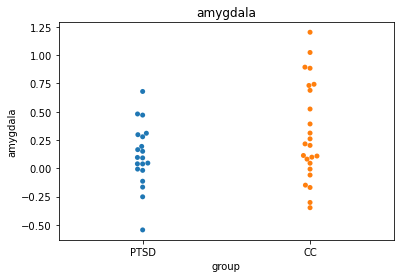

In [10]:
# Plot barplot to see differences
plt.title("amygdala")
#sns.barplot(x="group", y="amygdala", data=dfAll, ci=68)
sns.swarmplot(x="group", y="amygdala", data=dfAll)#, ci=68)

## Use STAN to check differences

In [11]:
#To select rows whose column value is in list 
groups = ["CC", "PTSD"]
dg = dfAll[dfAll.group.isin(groups)]

# changing group to numbers before we run stan model
group = {'CC': 0,'PTSD': 1} 
dg.group = [group[item] for item in dg.group] 
dg.head()

,group,subject,amygdala,amgsem,amgstd
0,1,040,0.470255,0.022986,0.701370
1,1,029,0.480097,0.027650,0.843667
2,0,020,0.260270,0.022249,0.678866
3,0,1072,0.893891,0.022684,0.692152
4,1,1074,0.045975,0.026153,0.797999


In [12]:
# how many in each group
dg.groupby(['group']).count()

,subject,amygdala,amgsem,amgstd
group,,,,
0,24,24,24,24
1,20,20,20,20


In [13]:
data =  {'N': len(dg), 'x': dg['group'].values, 'y': dg['amygdala'].values}
sm = cmdstanpy.CmdStanModel(stan_file='Stan_model/simple_model.stan')


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/or/SIA_PTSD/Stan_model/simple_model


In [14]:
# Train the model and generate samples
seed = 1332 # set random seed
fit_simple_model = sm.sample(
  data = data,
  chains = 4,
  iter_warmup = 1000,
  iter_sampling = 1000,
  adapt_delta = .9,
  seed = seed
  #inits = 0.2,
)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


In [15]:
#fit
fit_simple_model.summary(percentiles=(4.5,95.5))

,Mean,MCSE,StdDev,4.5%,95.5%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,
lp__,20.00,0.03200,1.300,17.00,22.000,1600.0,19000.0,1.0
alpha,0.31,0.00170,0.076,0.18,0.430,2100.0,24000.0,1.0
beta,-0.20,0.00240,0.110,-0.40,-0.016,2200.0,26000.0,1.0
sigma,0.38,0.00086,0.044,0.31,0.460,2600.0,30000.0,1.0


In [16]:
# # Extracting traces
alpha = fit_simple_model.stan_variable(name='alpha')
beta = fit_simple_model.stan_variable(name='beta')
sigma = fit_simple_model.stan_variable(name='sigma')
#lp = fit_simple_model.stan_variable(name='lp')

In [17]:

np.percentile(beta, [4.5, 95.5])

array([-0.39500182, -0.01081919])

0.038250000000000006

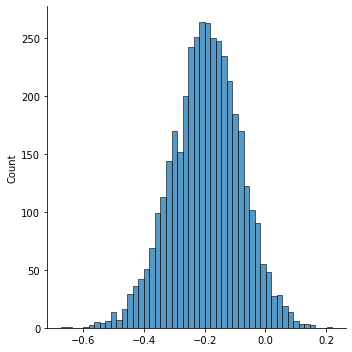

In [18]:
sns.displot(beta)
1 - sum(beta<0) / len(beta)

# Check correlation between amg and behavior

In [19]:
dfPCL = pd.read_csv('pclScores.csv')
# remove the RCF from beginning of subject id
dfPCL['subject'] = dfPCL['subject'].astype(str)
# because some subjects has two digits, we add zero
for i in dfPCL.iterrows():
    if len(i[1].subject) < 4:
        dfPCL.at[i[0],'subject'] = '0' + i[1].subject

dfPCL.head()

,group,subject,pcl_An,pcl_Av,pcl_total
0,PTSD,035,7.0,6.0,43.0
1,CC,011,0.0,0.0,0.0
2,PTSD,040,5.0,4.0,24.0
3,PTSD,029,0.0,1.0,11.0
4,CC,020,0.0,0.0,0.0


In [20]:
# other data
dfPCL = pd.read_csv('behavioural/pcl_allClust.csv', dtype={'subject':str, 'subject_id':str})
dfPCL

,subject_id,Int,Av,NA,An,EB,AA,DA,group,subject,pcl_An,pcl_Av,pcl_total
0,1359,3.0,2.0,1.0,2.0,0.0,4.0,2.0,PTSD,1359,2.0,2.0,14.0
1,011,0.0,0.0,0.0,0.0,NaN,0.0,0.0,CC,011,0.0,0.0,0.0
2,020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CC,020,0.0,0.0,0.0
3,029,4.0,1.0,1.0,0.0,0.0,4.0,1.0,PTSD,029,0.0,1.0,11.0
4,030,3.0,1.0,2.0,0.0,0.0,4.0,2.0,FPTSD,030,0.0,1.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,1444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,HC,1444,0.0,0.0,0.0
68,1445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,HC,1445,0.0,0.0,0.0
69,1449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,HC,1449,0.0,0.0,0.0
70,1457,2.0,0.0,0.0,3.0,1.0,0.0,2.0,CC,1457,3.0,0.0,8.0


In [21]:
## Add BDI as well
dfBDI = pd.read_csv('behavioural/ReconsolidationOfFea_DATA_2021-10-26_1335.csv')
dfBDI.head()

,subject_id,redcap_event_name,bdi_1_sadness,bdi_2_pessimism,bdi_3_pastfailure,bdi_4_pleasure,bdi_5_guilt,bdi_6_punishment,bdi_7_selfdislike,bdi_8_selfcriticalness,...,bdi_13_indecisiveness,bdi_14_worthlessness,bdi_15_lossenergy,bdi_16_sleep,bdi_17_irritability,bdi_18_appetite,bdi_19_concentration,bdi_20_fatigue,bdi_21_sex,bdiii_complete
0,RCF020,self_reports_arm_1,0,0,0,0,0,0.0,0,0,...,0,0,1,2.0,0,0.0,1,1,1,2
1,RCF029,self_reports_arm_1,0,0,0,0,0,0.0,0,0,...,0,0,0,0.0,0,0.0,0,0,0,2
2,RCF040,self_reports_arm_1,1,2,2,2,2,2.0,2,2,...,1,2,1,1.0,2,0.0,2,1,1,2
3,RCF1072,self_reports_arm_1,0,1,0,1,0,0.0,1,0,...,0,0,1,2.0,0,1.0,0,1,0,2
4,RCF1074,self_reports_arm_1,2,2,0,2,2,0.0,1,1,...,1,1,1,4.0,1,2.0,2,2,1,2


In [22]:

sumBDI = np.sum(dfBDI.iloc[:,2:23], axis=1) # sum BDI scores
sumBDI
dfBDI['sum_bdi'] = sumBDI
dfBDI = dfBDI[['subject_id', 'sum_bdi']]

for i in dfBDI.iterrows():
    #print(i[1].subject_id)
    sub = i[1].subject_id.split('RCF')[1]
  #  print(sub)
    dfBDI.at[i[0], 'subject_id'] = sub
  
dfBDI.head()

,subject_id,sum_bdi
0,020,6.0
1,029,1.0
2,040,31.0
3,1072,8.0
4,1074,29.0


In [23]:
groups = ["CC", "PTSD"]
dfpcl_amg = pd.merge(dfPCL, amg_ud)
dfpcl_amg = dfpcl_amg[dfpcl_amg.group.isin(groups)]
dfpcl_amg.head()

,subject_id,Int,Av,NA,An,EB,AA,DA,group,subject,pcl_An,pcl_Av,pcl_total,amygdala,amgsem,amgstd
0,1359,3.0,2.0,1.0,2.0,0.0,4.0,2.0,PTSD,1359,2.0,2.0,14.0,0.039414,0.022593,0.689376
1,020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CC,020,0.0,0.0,0.0,0.260270,0.022249,0.678866
2,029,4.0,1.0,1.0,0.0,0.0,4.0,1.0,PTSD,029,0.0,1.0,11.0,0.480097,0.027650,0.843667
3,040,3.0,4.0,4.0,5.0,2.0,2.0,4.0,PTSD,040,5.0,4.0,24.0,0.470255,0.022986,0.701370
4,1072,2.0,0.0,2.0,1.0,1.0,4.0,4.0,CC,1072,1.0,0.0,14.0,0.893891,0.022684,0.692152


In [24]:
# add sum bdi
dfpcl_amg_bdi = pd.merge(dfpcl_amg, dfBDI, left_on='subject', right_on='subject_id')
dfpcl_amg_bdi.head()

,subject_id_x,Int,Av,NA,An,EB,AA,DA,group,subject,pcl_An,pcl_Av,pcl_total,amygdala,amgsem,amgstd,subject_id_y,sum_bdi
0,1359,3.0,2.0,1.0,2.0,0.0,4.0,2.0,PTSD,1359,2.0,2.0,14.0,0.039414,0.022593,0.689376,1359,1.0
1,020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CC,020,0.0,0.0,0.0,0.260270,0.022249,0.678866,020,6.0
2,029,4.0,1.0,1.0,0.0,0.0,4.0,1.0,PTSD,029,0.0,1.0,11.0,0.480097,0.027650,0.843667,029,1.0
3,040,3.0,4.0,4.0,5.0,2.0,2.0,4.0,PTSD,040,5.0,4.0,24.0,0.470255,0.022986,0.701370,040,31.0
4,1072,2.0,0.0,2.0,1.0,1.0,4.0,4.0,CC,1072,1.0,0.0,14.0,0.893891,0.022684,0.692152,1072,8.0


## generate publication plots

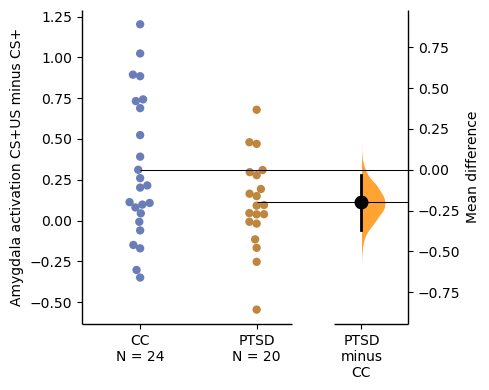

In [25]:
import dabest
groups = ["CC", "PTSD"]
dgr = dfAll[dfAll.group.isin(groups)]

# load our data to dabest to produce graphs
dgr = dgr.rename(columns={"amygdala": "Amygdala activation CS+US minus CS+", "group": "Group"})
dgr_dabest = dabest.load(data=dgr, x='Group', y='Amygdala activation CS+US minus CS+', 
                                  idx=('CC','PTSD'), ci=89)
g1 = dgr_dabest.mean_diff.plot(custom_palette={'CC':'royalblue','PTSD':'darkorange'})
#g1.savefig('cleanData_RCF.png', dpi=300, bbox_inches="tight")

## Robust regression using Stan

In [26]:
data =  {'N': len(dfpcl_amg), 'x': dfpcl_amg['amygdala'].values, 'y': dfpcl_amg['An'].values}
sm_robust = cmdstanpy.CmdStanModel(stan_file='Stan_model/robust_reg.stan')


In [27]:
seedRubost = 156 # seed
fit_robust_reg = sm_robust.sample(
  data = data,
  chains = 4,
  iter_warmup = 1000,
  iter_sampling = 1000,
  adapt_delta = .9,
  seed = seedRubost
  #inits = 0.2,
)

In [28]:
fit_robust_reg.summary(percentiles=(4.5,95.5))

,Mean,MCSE,StdDev,4.5%,95.5%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,
lp__,-90.0,0.052,1.60,-93.0,-88.0,880.0,5700.0,1.0
alpha,4.3,0.014,0.63,3.2,5.3,2000.0,13000.0,1.0
beta,-3.6,0.033,1.40,-6.1,-1.2,1900.0,12000.0,1.0
sigma,3.3,0.010,0.42,2.6,4.1,1700.0,11000.0,1.0
nu,24.0,0.530,15.00,6.1,53.0,770.0,5000.0,1.0


In [29]:
alpha = fit_robust_reg.stan_variable(name='alpha')
beta = fit_robust_reg.stan_variable(name='beta')

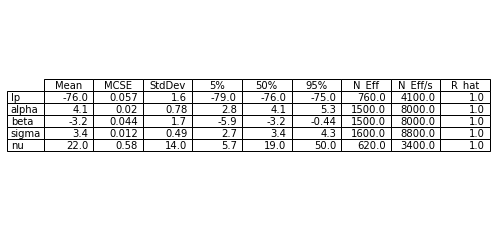

In [101]:
## Create a table
df_fit = fit_robust_reg.summary()
plt.rcParams["figure.figsize"] = [8, 4]
fig, ax =plt.subplots(1,1)
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=df_fit.values,colLabels=df_fit.columns,
         rowLabels=["lp_","alpha","beta", "sigma", "nu"],loc="center")
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


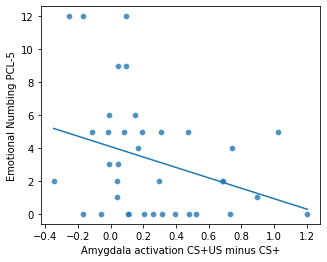

In [102]:
# plot a line based on the robust regression
plt.figure(figsize=(5,4))
line = np.mean(alpha) + np.mean(beta)*dfpcl_amg.amygdala
fgrid = sns.scatterplot(y='pcl_An', x='amygdala',data=dfpcl_amg, alpha=0.8)
#plt.plot(dfpcl_amg.amygdala, line)#,alpha = 0.8)
sns.lineplot(dfpcl_amg.amygdala, line)
fgrid.set(ylabel='Emotional Numbing PCL-5', xlabel='Amygdala activation CS+US minus CS+')
plt.savefig('RCF_robustRegression.png', dpi=300, bbox_inches="tight")

## BDI Robust regression

In [78]:
data =  {'N': len(dfpcl_amg_bdi), 'x': dfpcl_amg_bdi['amygdala'].values, 'y': dfpcl_amg_bdi['sum_bdi'].values}
sm_robust = cmdstanpy.CmdStanModel(stan_file='Stan_model/robust_reg.stan')


In [79]:
seedRubost = 156 # seed
fit_robust_regBDI = sm_robust.sample(
  data = data,
  chains = 4,
  iter_warmup = 1000,
  iter_sampling = 1000,
  adapt_delta = .9,
  seed = seedRubost
  #inits = 0.2,
)

In [80]:
fit_robust_regBDI.summary(percentiles=(4.5,95.5))

,Mean,MCSE,StdDev,4.5%,95.5%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,
lp__,-130.0,0.047,1.5,-130.0,-120.0,1000.0,6100.0,1.0
alpha,13.0,0.062,2.7,8.2,17.0,1800.0,11000.0,1.0
beta,-3.9,0.120,5.3,-13.0,5.0,2000.0,11000.0,1.0
sigma,13.0,0.043,1.7,10.0,16.0,1600.0,9300.0,1.0
nu,22.0,0.490,14.0,5.2,50.0,840.0,4900.0,1.0


In [85]:
alpha = fit_robust_regBDI.stan_variable(name='alpha')
beta = fit_robust_regBDI.stan_variable(name='beta')

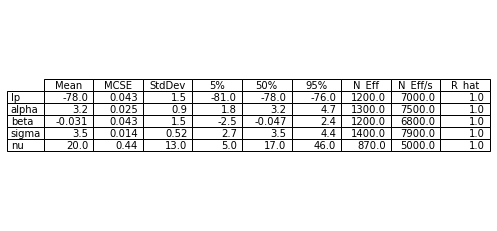

In [86]:
## Create a table
df_fit = fit_robust_reg.summary()
plt.rcParams["figure.figsize"] = [8, 4]
fig, ax =plt.subplots(1,1)
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=df_fit.values,colLabels=df_fit.columns,
         rowLabels=["lp_","alpha","beta", "sigma", "nu"],loc="center")
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)

In [93]:
# save results as image
import dataframe_image as dfi
tRobust = az.from_cmdstanpy(fit_robust_regBDI)

In [94]:
dfi.export(az.summary(tRobust, hdi_prob=.89), 'RobustReg_ResultsBDI.png')

[0410/044708.291029:WARNING:bluez_dbus_manager.cc(248)] Floss manager not present, cannot set Floss enable/disable.


/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


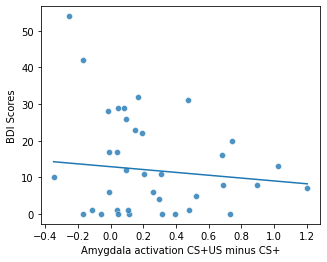

In [87]:
# plot a line based on the robust regression
plt.figure(figsize=(5,4))
line = np.mean(alpha) + np.mean(beta)*dfpcl_amg_bdi.amygdala
fgrid = sns.scatterplot(y='sum_bdi', x='amygdala',data=dfpcl_amg_bdi, alpha=0.8)
#plt.plot(dfpcl_amg.amygdala, line)#,alpha = 0.8)
sns.lineplot(dfpcl_amg_bdi.amygdala, line)
fgrid.set(ylabel='BDI Scores', xlabel='Amygdala activation CS+US minus CS+')
plt.savefig('RCF_robustRegressionBDI.png', dpi=300, bbox_inches="tight")

## PCL Clusters

In [103]:
# Intrusion
dfpcl_amg['Int'].values
# there are Nans - so remove them
dfpcl_noNans = dfpcl_amg.dropna()
dfpcl_noNans['Int'].values

array([ 3.,  0.,  4.,  3.,  2., 13.,  5., 10.,  2., 12.,  0., 11.,  5.,
        8., 14.,  1.,  0.,  0., 11.,  4.,  0., 11.,  0.,  3., 12.,  0.,
        3., 12., 13., 12., 11.,  2., 14.,  0.,  2.,  7.])

In [104]:
data =  {'N': len(dfpcl_noNans), 'x': dfpcl_noNans['amygdala'].values, 'y': dfpcl_noNans['Int'].values}
sm_robust = cmdstanpy.CmdStanModel(stan_file='Stan_model/robust_reg.stan')


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/or/SIA_PTSD/Stan_model/robust_reg


In [105]:
seedRubost = 158 # seed
fit_robust_reg = sm_robust.sample(
  data = data,
  chains = 4,
  iter_warmup = 1000,
  iter_sampling = 1000,
  adapt_delta = .9,
  seed = seedRubost
  #inits = 0.2,
)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


In [106]:
fit_robust_reg.summary(percentiles=(4.5,95.5))

,Mean,MCSE,StdDev,4.5%,95.5%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,
lp__,-88.0,0.050,1.5,-92.0,-87.0,950.0,7000.0,1.0
alpha,6.4,0.027,1.1,4.4,8.3,1700.0,13000.0,1.0
beta,-2.6,0.061,2.5,-6.9,1.4,1600.0,12000.0,1.0
sigma,5.2,0.015,0.7,4.1,6.4,2300.0,17000.0,1.0
nu,26.0,0.570,15.0,7.5,55.0,710.0,5200.0,1.0


In [107]:
# save results as image
import dataframe_image as dfi
tRobust = az.from_cmdstanpy(fit_robust_reg)
dfi.export(az.summary(tRobust, hdi_prob=.89), 'RobustReg_ResultsIntrusion.png')

In [ ]:
# Avoidance


In [108]:
data =  {'N': len(dfpcl_noNans), 'x': dfpcl_noNans['amygdala'].values, 'y': dfpcl_noNans['Av'].values}
sm_robust = cmdstanpy.CmdStanModel(stan_file='Stan_model/robust_reg.stan')


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/or/SIA_PTSD/Stan_model/robust_reg


In [109]:
seedRubost = 159 # seed
fit_robust_regAv = sm_robust.sample(
  data = data,
  chains = 4,
  iter_warmup = 1000,
  iter_sampling = 1000,
  adapt_delta = .9,
  seed = seedRubost
  #inits = 0.2,
)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


In [110]:
fit_robust_regAv.summary(percentiles=(4.5,95.5))

,Mean,MCSE,StdDev,4.5%,95.5%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,
lp__,-62.0,0.0470,1.60,-66.0,-60.00,1200.0,7300.0,1.0
alpha,2.9,0.0120,0.53,1.9,3.70,1900.0,12000.0,1.0
beta,-1.7,0.0270,1.20,-3.9,0.31,2000.0,13000.0,1.0
sigma,2.4,0.0077,0.34,1.9,3.10,2000.0,12000.0,1.0
nu,25.0,0.4900,15.00,6.8,55.00,970.0,6100.0,1.0


In [111]:
tRobust = az.from_cmdstanpy(fit_robust_regAv)
dfi.export(az.summary(tRobust, hdi_prob=.89), 'RobustReg_ResultsAv.png')

In [112]:
# Negative Affect

In [113]:
data =  {'N': len(dfpcl_noNans), 'x': dfpcl_noNans['amygdala'].values, 'y': dfpcl_noNans['NA'].values}
sm_robust = cmdstanpy.CmdStanModel(stan_file='Stan_model/robust_reg.stan')


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/or/SIA_PTSD/Stan_model/robust_reg


In [114]:
seedRubost = 171 # seed
fit_robust_regNA = sm_robust.sample(
  data = data,
  chains = 4,
  iter_warmup = 1000,
  iter_sampling = 1000,
  adapt_delta = .9,
  seed = seedRubost
  #inits = 0.2,
)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3


In [115]:
fit_robust_regNA.summary(percentiles=(4.5,95.5))

,Mean,MCSE,StdDev,4.5%,95.5%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,
lp__,-81.0,0.044,1.50,-85.0,-80.00,1100.0,7100.0,1.0
alpha,4.8,0.024,0.93,3.1,6.30,1500.0,10000.0,1.0
beta,-3.6,0.050,2.00,-7.1,-0.39,1600.0,11000.0,1.0
sigma,4.2,0.018,0.59,3.2,5.20,1100.0,7200.0,1.0
nu,23.0,0.520,14.00,5.3,51.00,770.0,5000.0,1.0


In [116]:
tRobust = az.from_cmdstanpy(fit_robust_regNA)
dfi.export(az.summary(tRobust, hdi_prob=.89), 'RobustReg_ResultsNA.png')

In [ ]:
# Externalized behaviour

In [118]:
data =  {'N': len(dfpcl_noNans), 'x': dfpcl_noNans['amygdala'].values, 'y': dfpcl_noNans['EB'].values}
sm_robust = cmdstanpy.CmdStanModel(stan_file='Stan_model/robust_reg.stan')

seedRubost = 172 # seed
fit_robust_regEB = sm_robust.sample(
  data = data,
  chains = 4,
  iter_warmup = 1000,
  iter_sampling = 1000,
  adapt_delta = .9,
  seed = seedRubost
  #inits = 0.2,
)

fit_robust_regEB.summary(percentiles=(4.5,95.5))

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/or/SIA_PTSD/Stan_model/robust_reg
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


,Mean,MCSE,StdDev,4.5%,95.5%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,
lp__,-58.00,0.040,1.40,-61.0,-56.00,1300.0,8700.0,1.0
alpha,2.00,0.014,0.49,1.1,2.80,1200.0,8200.0,1.0
beta,-0.73,0.027,1.00,-2.5,0.95,1500.0,9700.0,1.0
sigma,2.10,0.014,0.31,1.6,2.60,530.0,3500.0,1.0
nu,22.00,0.500,14.00,4.8,48.00,730.0,4800.0,1.0


In [119]:
tRobust = az.from_cmdstanpy(fit_robust_regEB)
dfi.export(az.summary(tRobust, hdi_prob=.89), 'RobustReg_ResultsEB.png')

In [120]:
# Dysphoric Arousal
data =  {'N': len(dfpcl_noNans), 'x': dfpcl_noNans['amygdala'].values, 'y': dfpcl_noNans['DA'].values}
sm_robust = cmdstanpy.CmdStanModel(stan_file='Stan_model/robust_reg.stan')

seedRubost = 173 # seed
fit_robust_regDA = sm_robust.sample(
  data = data,
  chains = 4,
  iter_warmup = 1000,
  iter_sampling = 1000,
  adapt_delta = .9,
  seed = seedRubost
  #inits = 0.2,
)

fit_robust_regDA.summary(percentiles=(4.5,95.5))

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/or/SIA_PTSD/Stan_model/robust_reg
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


,Mean,MCSE,StdDev,4.5%,95.5%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,
lp__,-62.0,0.0390,1.50,-66.0,-61.00,1500.0,12000.0,1.0
alpha,3.4,0.0120,0.53,2.4,4.30,1900.0,14000.0,1.0
beta,-1.1,0.0290,1.20,-3.2,0.92,1700.0,13000.0,1.0
sigma,2.5,0.0073,0.33,2.0,3.00,2000.0,15000.0,1.0
nu,26.0,0.3800,14.00,7.6,52.00,1500.0,11000.0,1.0


In [121]:
tRobust = az.from_cmdstanpy(fit_robust_regEB)
dfi.export(az.summary(tRobust, hdi_prob=.89), 'RobustReg_ResultsDA.png')

In [122]:
# Anxoius Arousal
data =  {'N': len(dfpcl_noNans), 'x': dfpcl_noNans['amygdala'].values, 'y': dfpcl_noNans['AA'].values}
sm_robust = cmdstanpy.CmdStanModel(stan_file='Stan_model/robust_reg.stan')

seedRubost = 173 # seed
fit_robust_regAA = sm_robust.sample(
  data = data,
  chains = 4,
  iter_warmup = 1000,
  iter_sampling = 1000,
  adapt_delta = .9,
  seed = seedRubost
  #inits = 0.2,
)

fit_robust_regAA.summary(percentiles=(4.5,95.5))

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/or/SIA_PTSD/Stan_model/robust_reg
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


,Mean,MCSE,StdDev,4.5%,95.5%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,
lp__,-68.0,0.0410,1.50,-71.0,-66.0,1300.0,9600.0,1.0
alpha,3.7,0.0140,0.61,2.7,4.7,1900.0,14000.0,1.0
beta,-1.2,0.0340,1.30,-3.5,1.1,1600.0,12000.0,1.0
sigma,2.9,0.0081,0.39,2.3,3.6,2300.0,17000.0,1.0
nu,26.0,0.4300,15.00,7.0,52.0,1100.0,8300.0,1.0


In [123]:
tRobust = az.from_cmdstanpy(fit_robust_regAA)
dfi.export(az.summary(tRobust, hdi_prob=.89), 'RobustReg_ResultsAA.png')